## Create data with artificial scores

In [62]:
import json
import random
import os

NUM_INTENTS = 10
NLU_NAMES = ['watson', 'luis', 'snips', 'rasa-sklearn', 'rasa-diet']

def get_nlu_result_dir(nlu, version):
    return '../results/' + nlu + '/v' + str(version)

def get_nlu_result_file(nlu, version, split_num):
    nlu_result_file = get_nlu_result_dir(nlu, version) + '/' + nlu + '_split_' + str(split_num) + '_results_v' + str(version) + '.json'
    return nlu_result_file

def normalize(vector):
    normalized_vector = [v/sum(vector) for v in vector]
    return normalized_vector

def set_random_descending_scores(test):
    scores = sorted([random.uniform(0,1) for _ in range(NUM_INTENTS)], key=lambda x: -x)
    if nlu != 'watson':
        scores = normalize(scores)
    for i in range(NUM_INTENTS):
        test['intent_ranking'][i]['confidence'] = scores[i]
        
def set_uniform_descending_scores(test):
    for i in range(NUM_INTENTS):
        test['intent_ranking'][i]['confidence'] = 1 - i/NUM_INTENTS

def ensure_dir_exists(path):
    if not os.path.exists(path):
        os.mkdir(path)

def create_results_with_artificial_scores(rescoring_function, dir_suffix):
    output_version = f'{VERSION}_{dir_suffix}'

    def create_results_for_nlu_and_split(nlu, split_num):
        data = json.load(open(get_nlu_result_file(nlu, VERSION, split_num)))
        for i in range(len(data)):
            test = data[i]
            if test['text'] != '':
                rescoring_function(test)
        json.dump(
            data, open(get_nlu_result_file(nlu, output_version, split_num), 'w'),
            indent=2)

    for nlu in NLU_NAMES:
        print(nlu)
        ensure_dir_exists(get_nlu_result_dir(nlu, output_version))
        for split_num in range(1, NUM_SPLITS+1):
            create_results_for_nlu_and_split(nlu, split_num)

create_results_with_artificial_scores(set_random_descending_scores, "random")

watson
luis
snips
rasa-sklearn
rasa-diet


## Rank-level score SD

watson


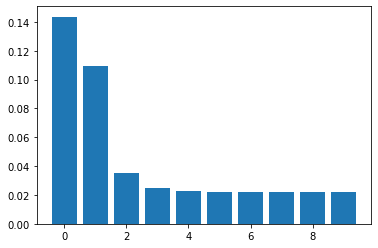

luis


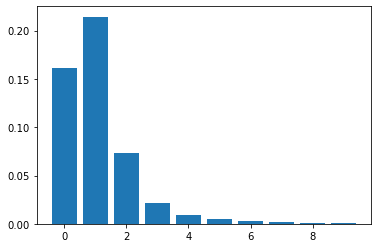

snips


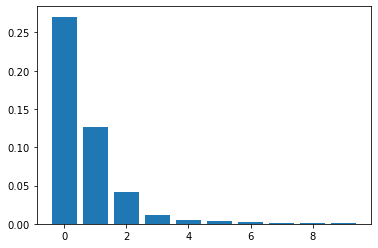

rasa-sklearn


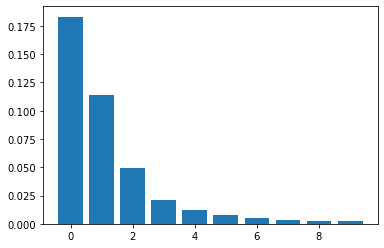

rasa-diet


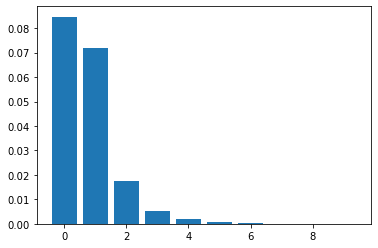

In [3]:
def get_scores(nlu, rank):
    for iteration in range(NUM_SPLITS):
        split_num = iteration + 1
        nlu_result_file = get_nlu_result_file(nlu, VERSION, split_num)
        data = remove_empty_preds(load_json(nlu_result_file))
        for test in data:
            yield test['intent_ranking'][rank]['confidence']

for i, nlu in enumerate(NLU_NAMES):
    print(nlu)
    sds = []
    for rank in range(NUM_INTENTS):
        #print('rank', rank)
        scores = list(get_scores(nlu, rank))
        sd = stdev(scores)
        #print(nlu, sd)
        sds.append(sd)
        
    fig, ax = plt.subplots()
    ax.bar(range(NUM_INTENTS), sds)
    plt.show()




